# MiniHack The Planet - Advantage Actor Critic

**Table of Contents**
1. Helper Functions
2. Advantage Actor Critic (A2C) Model 
3. A2C Algorithm 
4. A2C Evaluation <br>
    4.1  A2C Learning Simple Navigation Task (_Room 5x5 Environment_) <br>
    4.2 A2C Learning Simple Skill Acquisition Task (_Eat Environment_) <br>
    4.3 A2C Performance on _Quest-Hard Environment_

In [8]:
import numpy as np 
import gym
import minihack 
from nle import nethack 

import numpy as np 
import random
import matplotlib.pyplot as plt 
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import flatten

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Helper Functions

In [10]:
def moving_average(a, n):
    """Calculates the moving average of an array a with a window size n"""
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

In [11]:
def display_screen(state):
    """Displays the state as the screen in image form using the 'pixel' observation key"""
    screen = Image.fromarray(np.uint8(state['pixel']))
    display(screen)

In [12]:
def format_state(state):
    """Formats the state according to the input requirements of the Actor Critic Neural Network"""
    
    # Normalize and reshape for convolutional layer input
    glyphs = state["glyphs"]
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    
    # Normalize the message and reshape for the fully connected layer input 
    message = state["message"]
    if state["message"].max()>0: 
        # Occassionally the message is empty which will cause a Zero Division error 
        message = message/message.max()
    message = message.reshape((1,len(message)))
    
    state = {"glyphs":glyphs,"message":message}
    return state

In [13]:
def compute_returns(rewards, gamma):
    """Computes the discounted returns of a sequence of rewards achieved in a trajectory"""
    returns = []
    r= 0
    for reward in rewards[::-1]:
        r = reward + gamma*r
        returns.append(r)
    returns.reverse()
    returns = np.array(returns)
    
    # Standardize Returns 
    if np.mean(returns)!= 0:
         returns = returns - np.mean(returns)
    if np.std(returns) != 0:
        returns = returns/ np.std(returns)

    return returns

In [36]:
def plot_results(env_name,scores, color,ylim):
    """Plots the reward attained by an Agent at each step of training in 
        an environment for each iteration and average over all iterations"""
    
    plt.figure(figsize=(8,6))
    
    # Plot individual iterations 
    for score in scores:
        plt.plot(score, alpha =0.1, color=color)
    
    # Plot mean over all iterations
    mean = np.mean(scores,axis=0)
    plt.plot(mean, color=color,label="Mean Reward")
    
    plt.title(f"Actor Critic - {env_name}")
    plt.xlabel("Episode Number")
    plt.ylabel("Reward")
    plt.yticks(np.arange(ylim[0], ylim[1], 1.00))
    plt.legend(loc=4)
    plt.savefig(f"Actor-Critic-{env_name}.pdf")
    plt.show()

## 2. Advantage Actor Critic (A2C) Model 

In [15]:
class ActorCritic(nn.Module):
    """The Actor Critic Neural Network used to estimate the state value function and action probabilities"""
    def __init__(self,s_size=8,h_size=128, a_size=4):
        
        # The network architecture follows the popular lenet-5 CNN architeture 
        super(ActorCritic, self).__init__()
        
        # Initialize first set of convolutional and pooling layers with a ReLU activation function 
        self.conv1 = Conv2d(in_channels=1, out_channels=20,
                            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Initialize second set of of convolutional and pooling layers with a ReLU activation function 
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
                            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        # Initialize fully connected layers for glyph output after convolutional and pooling layers
        self.fc1 = Linear(in_features=1600, out_features=500)
        self.relu3 = ReLU()
        self.fc2 = Linear(in_features=500, out_features=128)
        self.relu4 = ReLU()
        
        # Initialize fully connected for message input 
        self.fc3 = Linear(in_features=256, out_features=128)
        self.relu5 = ReLU()
        
        # Initialize fully connected for combination of glyphs and message 
        self.fc4 = Linear(in_features=256, out_features=128)
        self.relu6 = ReLU()

        # To estimate the value function of the state 
        self.value_layer = nn.Linear(128, 1)

        # To calculate the probability of taking each action in the given state
        self.action_layer = nn.Linear(128, a_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, state):
        
        # Transform the glyph and state arrays into tensors 
        glyphs_t  = torch.from_numpy(state["glyphs"]).float().to(device)
        message_t  = torch.from_numpy(state["message"]).float().to(device)

        # Pass the 2D glyphs input through our convolutional and pooling layers 
        glyphs_t = self.conv1(glyphs_t)
        glyphs_t = self.relu1(glyphs_t)
        glyphs_t = self.maxpool1(glyphs_t)
        glyphs_t = self.conv2(glyphs_t)
        glyphs_t = self.relu2(glyphs_t)
        glyphs_t = self.maxpool2(glyphs_t)
        
        # Platten the output from the final pooling layer and pass it through the fully connected layers 
        glyphs_t = glyphs_t.reshape(glyphs_t.shape[0], -1)
        glyphs_t = self.fc1(glyphs_t)
        glyphs_t = self.relu3(glyphs_t)
        glyphs_t = self.fc2(glyphs_t)
        glyphs_t = self.relu4(glyphs_t)
        
        # Pass the message input through a fully connected layer
        message_t = self.fc3(message_t)
        message_t = self.relu5(message_t)
        
        # Combine glyphs output from convolution and fully connected layers 
        # with message output from fully connected layer 
        # Cat and Concat are used for different versions of PyTorch
        try:
            combined = torch.cat((glyphs_t,message_t),1)
        except:
            combined = torch.concat([glyphs_t,message_t],1)

        # Pass glyphs and messaged combination through a fully connected layer
        combined = self.fc4(combined)
        combined = self.relu6(combined)
        
        # Pass the output from the previous fully connected layer through two seperate 
        # fully connected layers, one with a single output neuron (to estimate the state value function)
        # and the other with the number of output neurons equal to the number of actions 
        # (to estimate the action probabilities)
        state_value = self.value_layer(combined)
        
        action_probs = self.action_layer(combined)
        action_probs = self.softmax(action_probs)
        
        return action_probs,state_value

## 3. A2C Algorithm 

In [39]:
def actor_critic(env, model, seed, learning_rate, number_episodes, max_episode_length, gamma, verbose=True):
    """
    Method to train Actor Critic model.
    
    Input:
    env: The environment to be used during training
    seed: The random seed for any random operations performed 
    learning_rate: The learning rate uesd for the Adam optimizer when training the model 
    number_episodes: Number of episodes to train for 
    max_episode_length: The maximum number of steps to take in an episode before terminating
    gamma: The discount factor used when calculating the discounted rewards of an episode
    verbose: Print episode reward after each episode
    
    Returns:
    policy: The neural network model after training that approximates the state value functions and action probabilities
    scores: The cumulative reward achieved by the agent for each episode during traiing
    """
    # Setting random seeds (for reproducibility)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    env.seed(seed)
    
    # Initialize optimizer for Actor Critic Network
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # List to store the rewards attained in each episode 
    scores =[]
    
    for i in range(number_episodes):
        # Reset environment
        state = format_state(env.reset())
        # Flag to see if episode has terminated
        done = False
        
        # Lists to store the rewards acquired, the log_probability of the actions and
        # the value function of the states visited in this episode 
        rewards = []
        log_probs = []
        state_values = []
        
        for t in range(1, max_episode_length):
            
            # Get the probability distribution over actions and 
            # estimated state value function from Actor Critic network 
            action_probs,state_value = model.forward(state)
            distribution = torch.distributions.Categorical(action_probs)
            # Sample from the probability distribution to determine which action to take 
            action = distribution.sample()
            
            # Take selected action, observe the reward received, the next state 
            # and whether or not the episode terminated 
            next_state, reward, done, _ = env.step(action.item())
            next_state = format_state(next_state)
    
            # Store the reward, log of the probability of the action selected 
            # And
            rewards.append(reward)
            log_probs.append(distribution.log_prob(action))
            state_values.append(state_value)
            
            state = next_state
            
            if done:
                break
        
        # Store the reward acquired in the episode and calculate the discounted return of the episode
        scores.append(np.sum(rewards))
        returns = compute_returns(rewards, gamma)
        returns = torch.from_numpy(returns).float().to(device)
        
        # Print the episode, the reward acquired in the episode and the mean reward over the last 50 episodes 
        if verbose:
            print("Episode:",i,"Reward:",np.sum(rewards),"Average Reward:",np.mean(scores[-50:]),"Steps",t)
        
        # Calculate the loss for the episode and use it to update the network parameters 
        loss = 0
        for logprob, value, reward in zip(log_probs, state_values, returns):
            advantage = reward  - value.item()
            action_loss = -logprob * advantage
            try:
                reward = reward.resize(1,1)
            except:pass
            value_loss = F.smooth_l1_loss(value, reward)
            loss += (action_loss + value_loss)   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        
    # Store the policy as the neural network model at the final iteration 
    policy = model

    return policy, scores

In [40]:
def run_actor_critic(env,number_episodes,max_episode_length,iterations):
    """Trains Actor Critic model for a number of episodes on a given environment"""
    seeds = np.random.randint(1000, size=iterations)
    scores_arr = [] 
    
    for seed in seeds:
        # Initialize the Actor Critic Model 
        ac_model = ActorCritic(h_size=512, a_size=env.action_space.n)

        # Train the Actor Critic Model 
        policy, scores = actor_critic(env=env,
                                    model= ac_model, 
                                    seed=seed, 
                                    learning_rate=0.02,
                                    number_episodes=number_episodes, 
                                    max_episode_length=max_episode_length, 
                                    gamma=0.99 ,
                                    verbose=True)
        
        # Store rewards for this iteration 
        scores_arr.append(scores)
        
    return scores_arr

## 4. Evaluation

## 4.1 Navigation - Room 5x5 

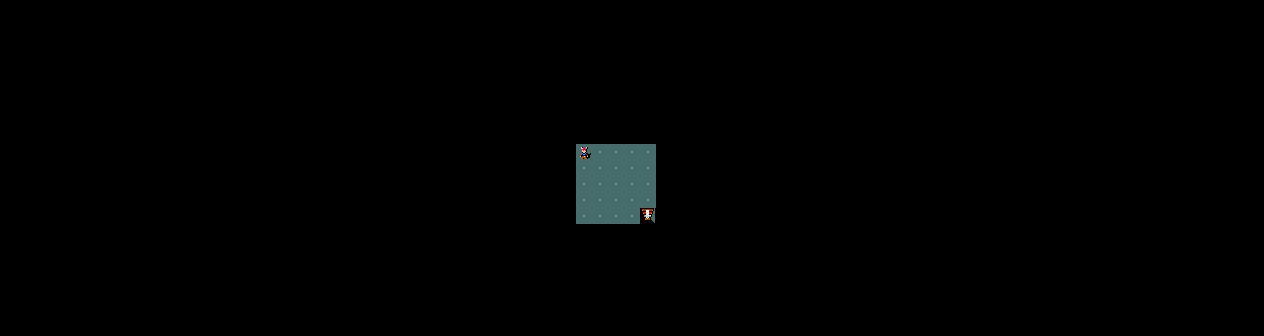

In [41]:
# Create the environment with the observations keys required as input to the Actor Critic Neural Network 
# The max number of epsidoe steps for the environment needs to be increased as it defaults to 250 for Navigation tasks
env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","pixel","message"],max_episode_steps=1000)

# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [36]:
room_5x5_scores = run_actor_critic(env,number_episodes=100,max_episode_length=1000,iterations=5)

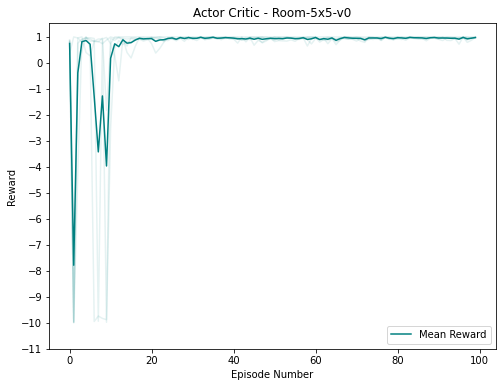

In [37]:
plot_results(env_name="Room-5x5-v0",scores=room_5x5_scores, ylim =(-11,2), color = "teal" )

## 4.2 Skill Acquisition - Eat 

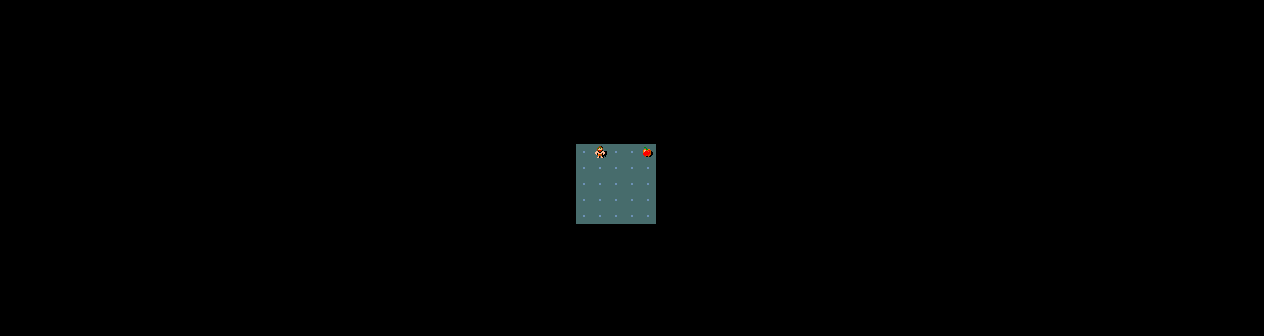

In [31]:
# By default Skill Acquisition tasks have an action space consisting of the full 78 actions available 
# Because most of these actions are unnecessary for smaller tasks we restrict the action space to the necessary 
# actions necesssary to complete the task in each environment only 
MOVE_ACTIONS = tuple(nethack.CompassDirection) # These are the cardinal directions
EAT_ACTIONS = MOVE_ACTIONS + (nethack.Command.EAT,) # Eat is to complete an episode by confirmation 


# Create the environment with the restricted action space as well as
# the observations keys required as input to the Actor Critic Neural Network 
env = gym.make("MiniHack-Eat-v0", observation_keys=["glyphs","pixel","message"],
               actions = EAT_ACTIONS, max_episode_steps=1000)
 
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())

In [39]:
# For skills acquisition tasks more training is required so not only are the episodes longer 
# but the number of episodes is also increased from 100 to 1000 
eat_scores = run_actor_critic(env,number_episodes=250,max_episode_length=1000,iterations=5)

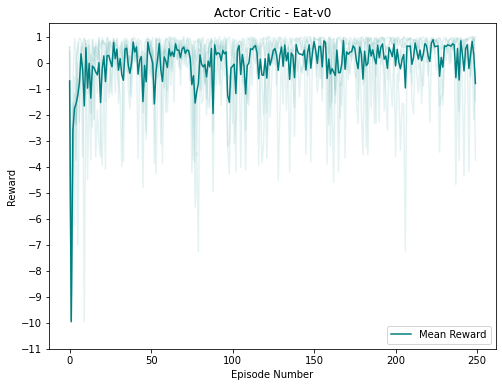

In [38]:
plot_results(env_name="Eat-v0",scores=eat_scores,  ylim= (-11,2),color = "teal")

## 3. Quest Hard 

In [45]:
# Restricting the action space
QUEST_ACTIONS = (
    nethack.CompassDirection.N,
    nethack.CompassDirection.E,
    nethack.CompassDirection.S,
    nethack.CompassDirection.W,
    nethack.CompassDirection.NW,
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP, 
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF
)

In [46]:
# Custom Reward for exploring more of the map 
def maze_explore_reward(env, prev_obs, action, next_obs):
    if (prev_obs[0] == 2359).sum() > (next_obs[0] == 2359).sum():
        return 0.1
    return 0

In [47]:
# Reward Manager for including custom rewards
from minihack import RewardManager

reward_gen = RewardManager()

# Random reward included to prevent reward glitch 
reward_gen.add_eat_event("apple", reward=1)

# Custom Rewards for long corridors at top and bottom 
reward_gen.add_coordinate_event((3,27), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((3,28), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((3,29), reward = -5, terminal_required = False)

reward_gen.add_coordinate_event((19,27), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((19,28), reward = -5, terminal_required = False)
reward_gen.add_coordinate_event((19,29), reward = -5, terminal_required = False)

reward_gen.add_coordinate_event((11,27), reward = 100, terminal_required = False)# first door at end of maze
reward_gen.add_custom_reward_fn(maze_explore_reward)

In [56]:
env = gym.make("MiniHack-Quest-Hard-v0", reward_manager = reward_gen, actions = QUEST_ACTIONS)

quest_hard_exp_scores = run_actor_critic(env, number_episodes = 500, max_episode_length = 1000,iterations = 5)

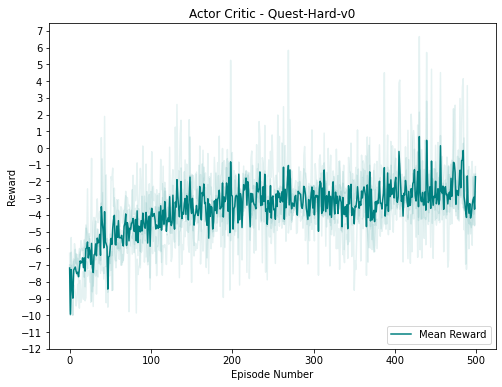

In [70]:
plot_results(env_name="Quest-Hard-v0",scores=quest_hard_exp_scores,ylim=(-12,8), color = "teal" )